URL del dataset:

https://www.kaggle.com/christianlillelund/csgo-round-winner-classification
    

Aclaracion: Cada una de las observaciones del dataset, describe el estado de una ronda y por lo tanto pueden tratarse individualmente. Aunque se pueden haber tomado distintas observaciones que pertenecen a la misma ronda.

Note: All the rows (round snapshots, captured at some random point doing a round) are i.i.d, which means they're not suppose to be dependent on each-other and you should really consider each row as an independent instance that describe some kind of round state (CT players alive, time left, has the bomb been planted, what weapons does each team have etc.) and an outcome (the round winner column). 

In [1]:
import numpy as np
import pandas as pd
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score, f1_score, plot_roc_curve

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier 
from lightgbm import plot_importance

from sklearn.inspection import permutation_importance # feature importance

from boruta import BorutaPy #dimensionality reduction

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
# Importamos los datos

data = pd.read_csv('Data/cs_go_grupo5.csv', index_col='Unnamed: 0')

df = data.copy()

In [3]:
df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


# EXPLORATORY DATA ANALYSIS (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121054 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     121054 non-null  float64
 1   ct_score                      121054 non-null  float64
 2   t_score                       121054 non-null  float64
 3   map                           121054 non-null  object 
 4   bomb_planted                  121054 non-null  bool   
 5   ct_health                     121054 non-null  float64
 6   t_health                      121054 non-null  float64
 7   ct_armor                      121054 non-null  float64
 8   t_armor                       121054 non-null  float64
 9   ct_money                      121054 non-null  float64
 10  t_money                       121054 non-null  float64
 11  ct_helmets                    121054 non-null  float64
 12  t_helmets                     121054 non-nul

#### **Se distinguen las siguientes featutres:**

*5 categorias independiente del equipo :*

   *    time_left                     121054 non-null  float64

   *    ct_score                      121054 non-null  float64

   *    t_score                       121054 non-null  float64

   *    map                           121054 non-null  object 

   *    bomb_planted                  121054 non-null  bool

TIME_LEFT describe el tiempo restante hasta el fin del round en segundos

ct_score y t_score dan el puntaje en el momento de la captura

map describe el mapa que se está jugando

bomb_planted define si está o no plantada la bomba



In [5]:
df.shape
print('El dataset se compone de ',df.shape[0],'filas y', df.shape[1],'columnas')

El dataset se compone de  121054 filas y 97 columnas


In [6]:
# Chequeamos si hay datos faltantes

df.isnull().any().any()

False

In [7]:
df.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.00000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.00000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.0,121054.00000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000
mean,97.779809,6.697152,6.768888,412.612892,403.256034,316.213632,300.425488,9835.801378,11299.019446,2.065822,2.790845,1.621863,4.278677,4.271482,0.275356,1.251442,0.135320,0.007592,0.576420,0.322154,0.0,0.000083,0.152618,0.106308,0.00399,0.001727,0.110835,0.004725,0.0,0.000801,0.011136,0.111017,0.006386,3.313620,0.000008,0.0,0.064203,0.002718,1.082872,0.052216,0.007625,0.108224,0.004436,0.00005,0.001479,0.002784,0.002057,0.001974,0.148182,0.005675,0.0,0.000008,0.000991,0.000107,0.000165,0.000157,0.0,0.000058,0.0,0.00014,0.000710,0.0,0.239604,0.829076,0.060023,0.020611,0.046797,0.036736,0.007592,0.000264,0.441811,0.381590,0.061741,0.009326,3.182869,0.122747,0.237134,0.291911,0.174203,0.004981,0.008129,0.028194,0.906381,0.441200,1.865399,1.871330,1.552745,1.640747,1.010590,0.019462,0.047805,1.363846,0.027872,0.025914
std,54.274380,4.791150,4.824726,131.805923,139.401569,170.006382,173.772098,11223.205878,12175.515454,1.841998,2.008555,1.606205,1.200535,1.223086,0.585206,1.365961,0.461609,0.091163,0.673945,0.476927,0.0,0.009089,0.446796,0.380639,0.06304,0.041515,0.390294,0.070713,0.0,0.037356,0.112607,0.407292,0.083106,1.621623,0.002874,0.0,0.263595,0.053005,1.221081,0.245619,0.094628,0.413512,0.067688,0.0

In [8]:
# Convierto a categorico las features que corresponden

df.map=(df.map).astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121054 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   time_left                     121054 non-null  float64 
 1   ct_score                      121054 non-null  float64 
 2   t_score                       121054 non-null  float64 
 3   map                           121054 non-null  category
 4   bomb_planted                  121054 non-null  bool    
 5   ct_health                     121054 non-null  float64 
 6   t_health                      121054 non-null  float64 
 7   ct_armor                      121054 non-null  float64 
 8   t_armor                       121054 non-null  float64 
 9   ct_money                      121054 non-null  float64 
 10  t_money                       121054 non-null  float64 
 11  ct_helmets                    121054 non-null  float64 
 12  t_helmets                     

## ANALISIS DE VARIABLES MACRO A NIVEL RONDA:

Se distinguen las siguientes variables:
- Time left
- Scores
- Mapa
- ¿Está plantada la bomba? (booleano)
- Jugadores vivos (ct_players_alive, t_players_alive)
- Ganador final de la ronda (round_winner)

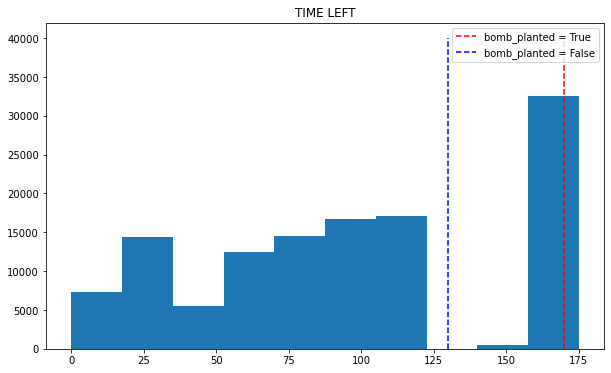

In [10]:
plt.figure(figsize=(10,6))
df.time_left.hist()
plt.vlines(x=170, ymin=0, ymax=40000, color='r', linestyles='--')
plt.vlines(x=130, ymin=0, ymax=40000, color='b', linestyles='--')
plt.title('TIME LEFT')
plt.legend(['bomb_planted = True','bomb_planted = False'])
plt.grid(False)
plt.show()

Las rondas de cs:go competitivo tienen una duracion maxima de 170 segundos, *si la bomba fue plantada*, caso contrario puede durar hasta 130 segundos:

    1) 15 sec. buy time.
    2) 115 sec. "action time".
    3) 40 sec. bomb plant (41 if we count the explosion animation).

Hay 33037 instancias con time_left > 130, donde la bomba no fue plantada

In [11]:
df[np.logical_and(df.time_left>130 , df.bomb_planted == False)].shape

(33037, 97)

CRITERIO ELEGIDO A PARTIR DE CONOCIMIENTO DE DOMINIO:

El maximo valor que aparece es 175, y dado que si la bomba no se encuentra plantada, el maximo tiempo que puede durar una ronda es 130 segundos, vamos a restarle **45 segundos** a estos casos.

In [12]:
index_time=df[np.logical_and(df.time_left>130 , df.bomb_planted == False)].index

df.loc[index_time,'time_left'] = df[np.logical_and(df.time_left>135 , df.bomb_planted == False)]['time_left'] - 45

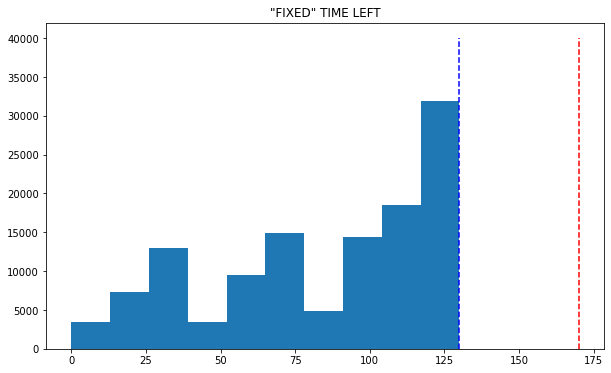

In [13]:
plt.figure(figsize=(10,6))
df.time_left.hist()
plt.vlines(x=170, ymin=0, ymax=40000, color='r', linestyles='--')
plt.vlines(x=130, ymin=0, ymax=40000, color='b', linestyles='--')
plt.title('"FIXED" TIME LEFT')
plt.grid(False)
plt.show()

### REVISAMOS LAS COMPRAS HECHAS POR LOS EQUIPOS

In [14]:
df_eda = df.iloc[:,11:96]
df_eda.head()

,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
for _ in range(df_eda.shape[1]):
    if df_eda.iloc[:,_].max() > 5:
        print(f'La columna {df_eda.columns[_]}, tiene {df_eda.iloc[:,_].max()} compras')

La columna t_weapon_cz75auto, tiene 6.0 compras
La columna t_weapon_glock, tiene 9.0 compras
La columna ct_weapon_usps, tiene 10.0 compras
La columna ct_grenade_flashbang, tiene 7.0 compras
La columna t_grenade_flashbang, tiene 7.0 compras
La columna ct_grenade_smokegrenade, tiene 6.0 compras
La columna t_grenade_smokegrenade, tiene 9.0 compras


Vemos algunos items que fueron comprados mas de 5 veces (uno por jugador), para el caso de la ct_weapon_usps y la t_weapon_glock, dado que son armas "muy economicas", puede ser que simplemente los jugadores las hayan dropeado sin razon. Para el caso de las granadas, se utiliza una estrategia que para elevar la cantidad de granadas que se puede utilizar. Un jugador normalmente por ronda puede llevar 1 granada de cada tipo, y solo puede comprar desde su lugar de spawn. Pero si uno compra una granada, la arroja al suelo, luego compra de nuevo la misma granada y la arroja desde el mismo lugar, puede volver a recojer la granada previamente dropeada, y de esta manera poder utilizar 2 granadas en esa ronda. Con lo cual los valores de las granadas parecieran tener sentido. Para el caso de t_weapon_cz75auto, es posible que algun jugador se haya equivocado en su compra, ya que una vez realizada una compra, no puede devolverse el arma.

### REVISAMOS CORRELACIONES

#### ARMOR AND HELMETS

Dado que es necesario tener armadura para poder comprar casco, vamos a revisar si hay una correlacion entre estas variables

##### LADO TT

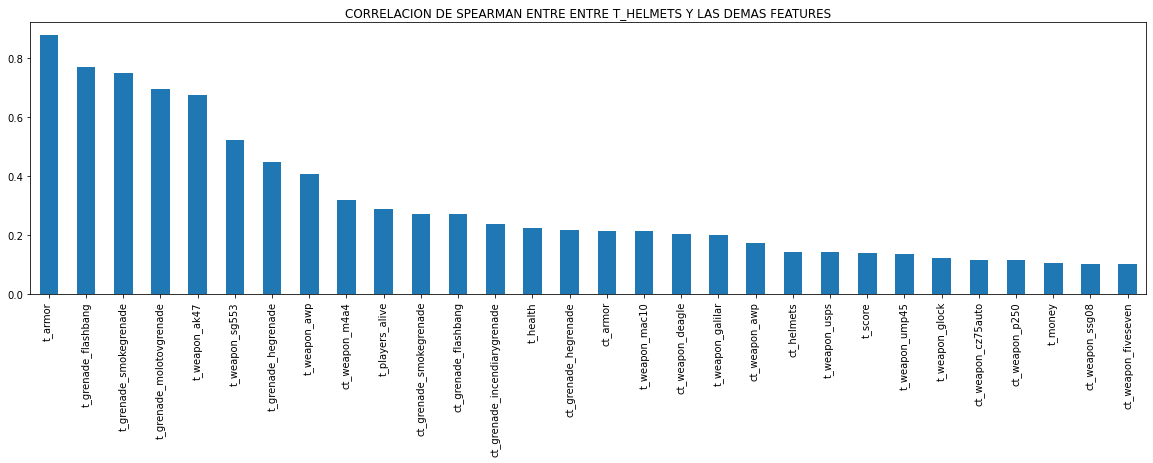

In [16]:
features_spearman_correlation_helm_t=(df.corr(method='pearson'))['t_helmets'].drop(index='t_helmets').sort_values(ascending = False)[:30]

features_spearman_correlation_helm_t.plot(kind='bar', figsize=(20,5), title = 'CORRELACION DE SPEARMAN ENTRE ENTRE T_HELMETS Y LAS DEMAS FEATURES')

plt.show()

Observamos una fuerte correlacion entre la armadura y los cascos. Esto en tareas de prediccion, no nos afectara, pero si en analisis de importancia de features. Por lo tanto, mas adelante, cuando hagamos el estudio de feature importance, vamos a eliminar la feature t_armor, y dejar solo t_helmets, ya que tener casco, implica necesariamente tener armadura, y la renombraremos a t_helmets_armor

##### LADO CT

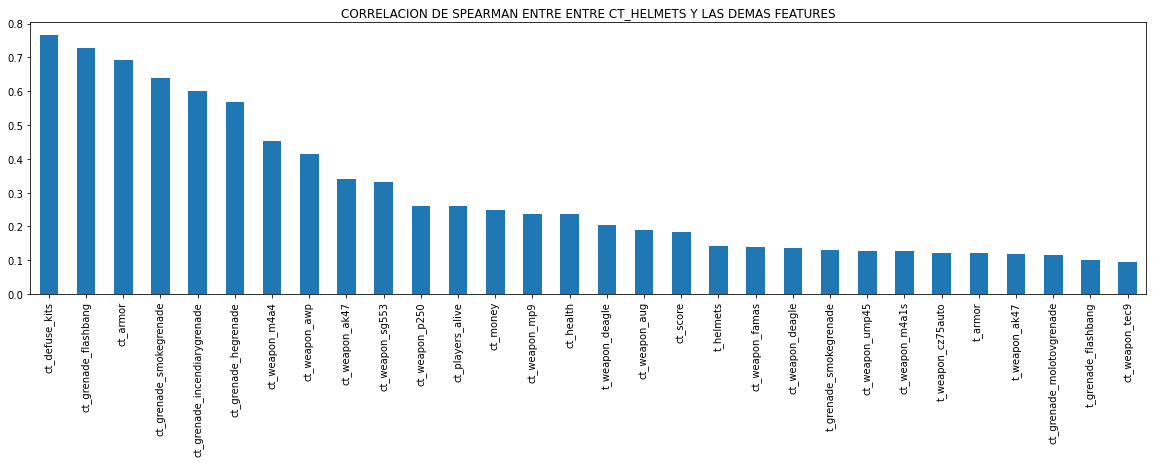

In [17]:
features_spearman_correlation_helm_ct=(df.corr(method='pearson'))['ct_helmets'].drop(index='ct_helmets').sort_values(ascending = False)[:30]

features_spearman_correlation_helm_ct.plot(kind='bar', figsize=(20,5), title = 'CORRELACION DE SPEARMAN ENTRE ENTRE CT_HELMETS Y LAS DEMAS FEATURES')

plt.show()

#### MONEY

##### LADO TT

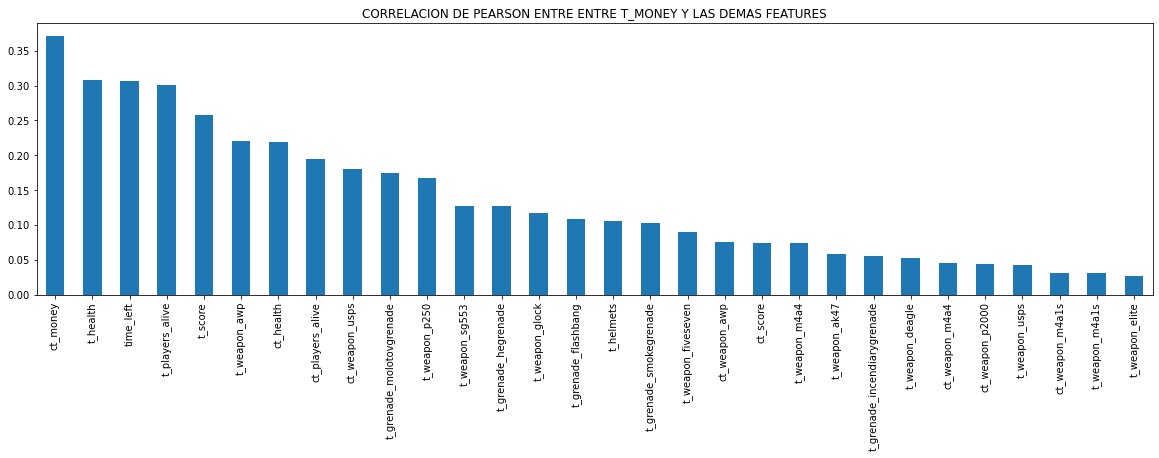

In [18]:
features_spearman_correlation_money_tt=(df.corr(method='pearson'))['t_money'].drop(index='t_money').sort_values(ascending = False)[:30]

features_spearman_correlation_money_tt.plot(kind='bar', figsize=(20,5), title = 'CORRELACION DE PEARSON ENTRE ENTRE T_MONEY Y LAS DEMAS FEATURES')

plt.show()

##### LADO CT

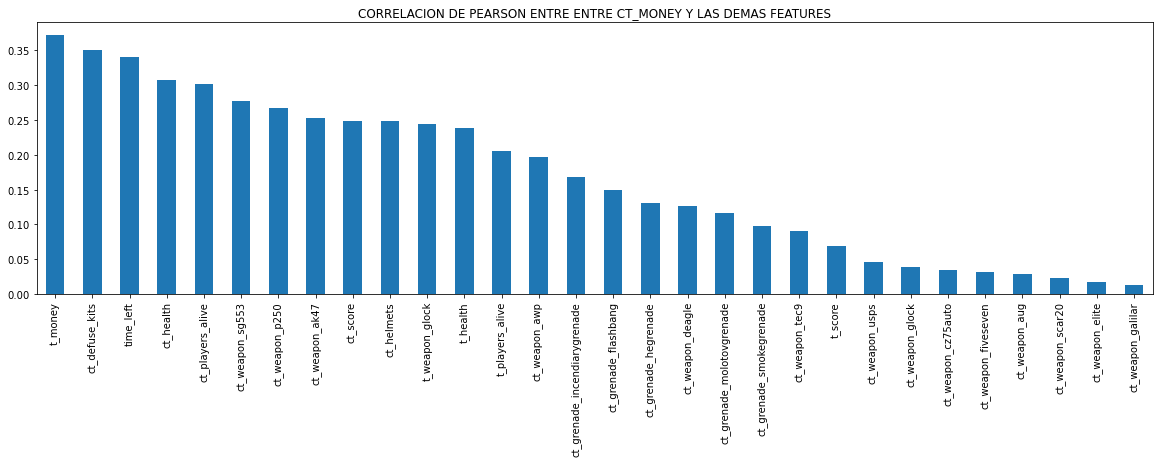

In [19]:
features_spearman_correlation_money_ct=(df.corr(method='pearson'))['ct_money'].drop(index='ct_money').sort_values(ascending = False)[:30]

features_spearman_correlation_money_ct.plot(kind='bar', figsize=(20,5), title = 'CORRELACION DE PEARSON ENTRE ENTRE CT_MONEY Y LAS DEMAS FEATURES')

plt.show()

No vemos una gran correlacion con ninguna feature en particular

### DISCRETIZAMOS EL TARGET


In [20]:

df['round_winner'] = df['round_winner'].map({'CT':0, 'T':1})

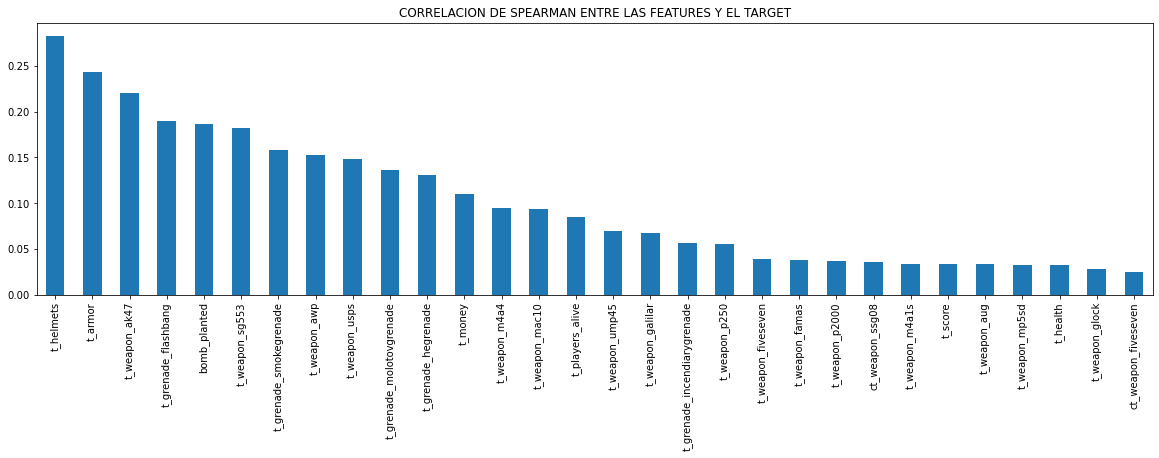

In [21]:
# Correlacion de Spearman es que cuando una feature aumenta, el valor del target aumenta 
# y viceversa, cuando el valor de una feature disminuye, el target, disminuye

features_spearman_correlation=(df.corr(method='spearman'))['round_winner'].drop(index='round_winner').sort_values(ascending = False)[:30]

features_spearman_correlation.plot(kind='bar', figsize=(20,5), title = 'CORRELACION DE SPEARMAN ENTRE LAS FEATURES Y EL TARGET')

plt.show()


Obtenemos las 5 features que mas se encuentran correlacionadas con el target, para luego realizar un pairplot

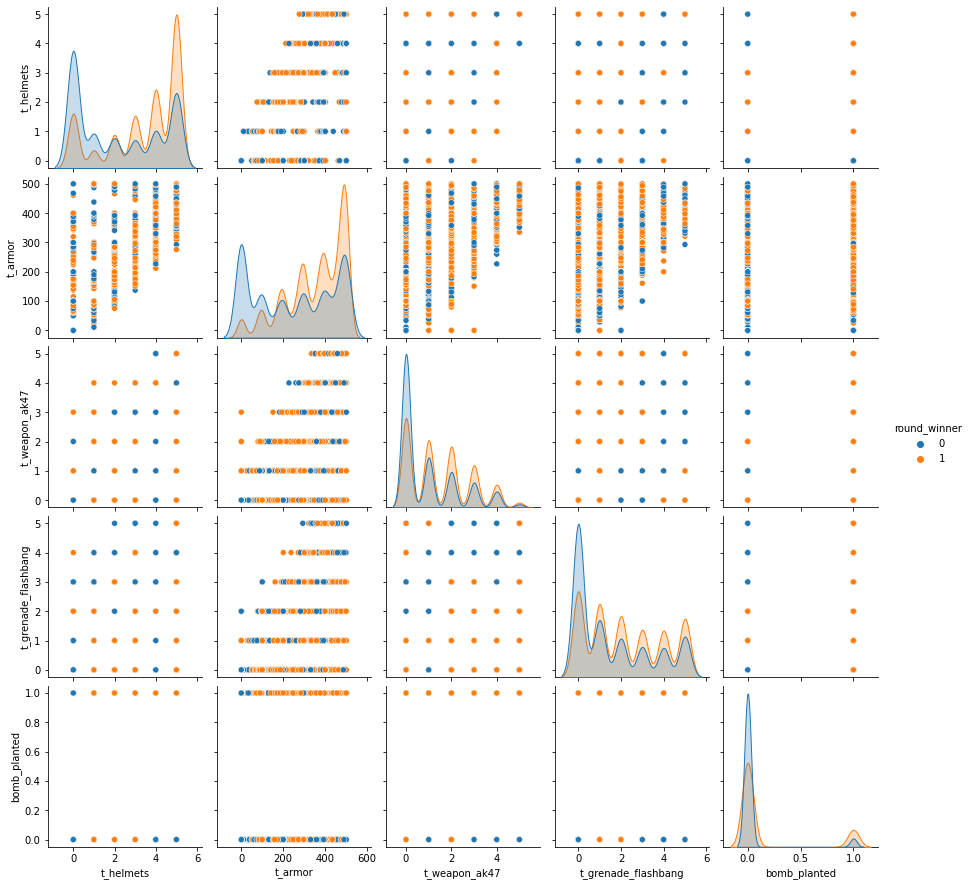

In [22]:
features_con_mayor_spearman_correlation=\
        (df.corr(method='spearman'))['round_winner'].drop(index='round_winner').sort_values(ascending = False)[:5].index

features_con_mayor_spearman_correlation=\
            pd.concat([df[features_con_mayor_spearman_correlation], df['round_winner']], axis=1)

features_con_mayor_spearman_correlation = features_con_mayor_spearman_correlation.sample(frac=0.25, random_state = 1204)

sns.pairplot(features_con_mayor_spearman_correlation, hue = 'round_winner')

plt.show()

La compra de cascos por el equipo atacante ayuda mucho a la victoria del mismo

Vemos un claro beneficio en plantar la bomba para la victoria `terrorist`

### ESTUDIAMOS LA DISTRIBUCION DE LA VARIABLE TARGET


In [23]:
df['round_winner'].value_counts(normalize = True)

1    0.51007
0    0.48993
Name: round_winner, dtype: float64

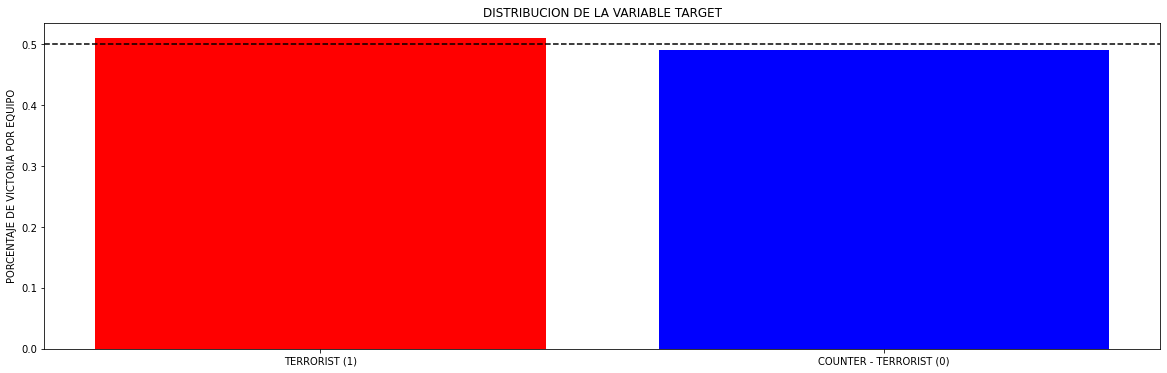

In [24]:
plt.figure(figsize=(20,6))
ax = plt.axes()
plt.hlines(y=0.5, xmin=-100, xmax=100, colors='k', linestyles = '--')
ax.bar(x= ['TERRORIST (1)', 'COUNTER - TERRORIST (0)'], height=df['round_winner'].value_counts(normalize = True), color=['r','b'])
plt.title('DISTRIBUCION DE LA VARIABLE TARGET')
plt.ylabel('PORCENTAJE DE VICTORIA POR EQUIPO')
# plt.grid()

plt.show()

**Parecen estar bastante balanceados ambos lados de juego, tanto el atacante como el defensor.**

### ESTUDIAMOS QUE MAPAS FUERON UTILIZADOS Y SU RELACION CON EL TARGET

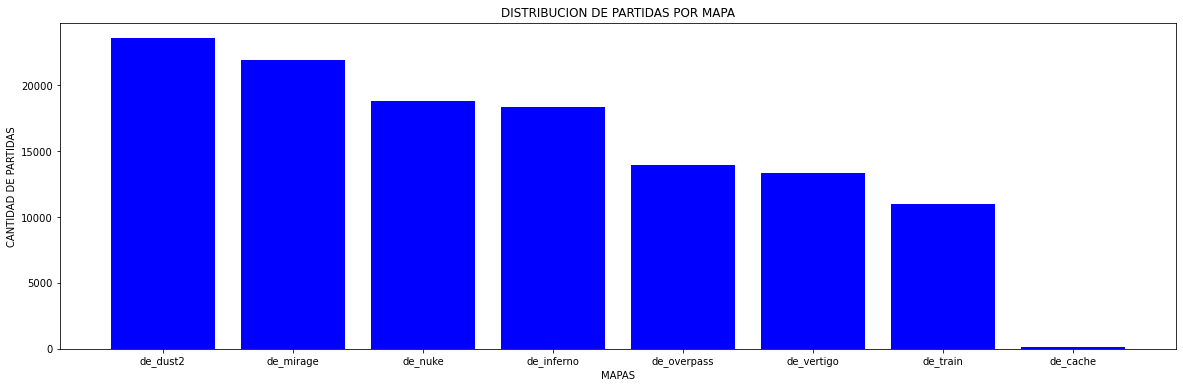

In [25]:
plt.figure(figsize=(20,6)); ax = plt.axes()
ax.bar(x= df.map.unique(),height=df.map.value_counts(), color='b')
plt.xlabel('MAPAS')
plt.ylabel('CANTIDAD DE PARTIDAS')
plt.title('DISTRIBUCION DE PARTIDAS POR MAPA')

plt.show()

In [26]:
mapas = df.map.unique()

ct_winrate_map=[df[df.map == mapa]['round_winner'].value_counts(normalize= True)[0] for mapa in mapas]
t_winrate_map=[df[df.map == mapa]['round_winner'].value_counts(normalize= True)[1] for mapa in mapas]

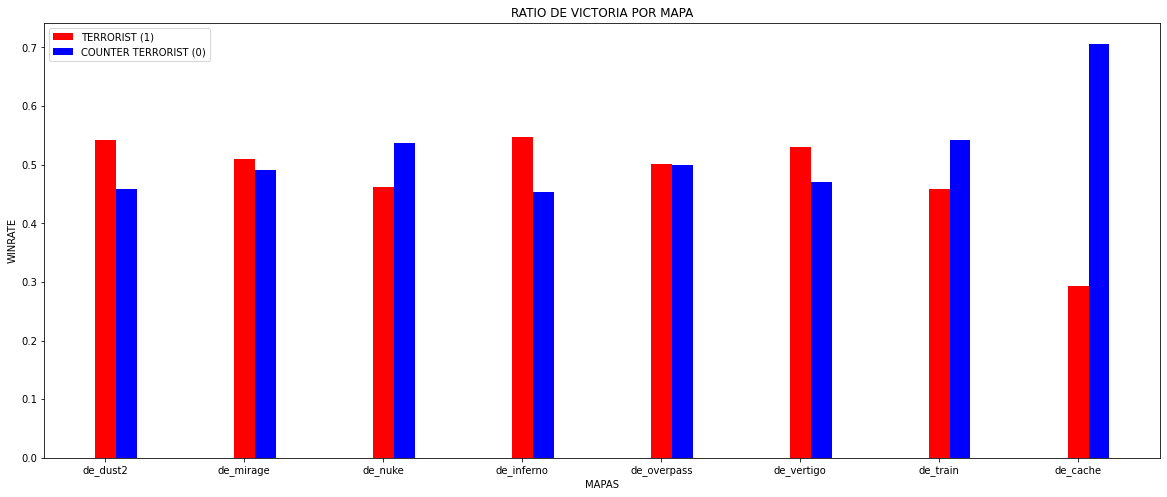

In [27]:
ind = np.arange(8) # crea la lista con numeros entre 0 y 4
width = 0.15 # ancho de las barras

fig = plt.figure(figsize=(20,8)); ax = plt.axes()
ax.bar(ind+ 0.00, t_winrate_map, width, color='r') # barra roja. 
ax.bar(ind+ 0.15, ct_winrate_map, width, color='b') # barra azul 


ax.set_title('RATIO DE VICTORIA POR MAPA')
ax.set_ylabel('WINRATE')
ax.set_xlabel('MAPAS')
ax.set_xticks(ind)
ax.set_xticklabels(mapas)
ax.legend(labels=['TERRORIST (1)', 'COUNTER TERRORIST (0)'])
# sns.set(font_scale = 1.5)
plt.show()

Vemos una gran ventaja para defender en el mapa `de_cache`, pero, fue muy poco utilizado

Vemos que estan bastante equilibrados los ratios entre ambos lados en los demas mapas

### ESTUDIAMOS LA BOMBA EN FUNCION DEL TARGET 

###### PORCENTAJE DE BOMBA PLANTADA EN LA PARTIDA

In [28]:
round(((df[df.bomb_planted==1].shape[0]/ df.shape[0])*100),2)

11.08

*Se planto la bomba en un 11% de las partidas*

In [29]:
victorias_bomba_plantada = pd.DataFrame(df.groupby('round_winner')['bomb_planted'].sum())

victorias_bomba_plantada['PORCENTAJE DE VICTORIA %'] = ((victorias_bomba_plantada['bomb_planted']/(victorias_bomba_plantada.sum()[0])*100).round(2))

victorias_bomba_plantada.rename(columns = {'bomb_planted':'VECES QUE FUE PLANTADA DE LA BOMBA'}, inplace=True)

victorias_bomba_plantada.index = ['COUNTER-TERRORIST','TERRORIST']

victorias_bomba_plantada

,VECES QUE FUE PLANTADA DE LA BOMBA,PORCENTAJE DE VICTORIA %
COUNTER-TERRORIST,3021,22.52
TERRORIST,10391,77.48


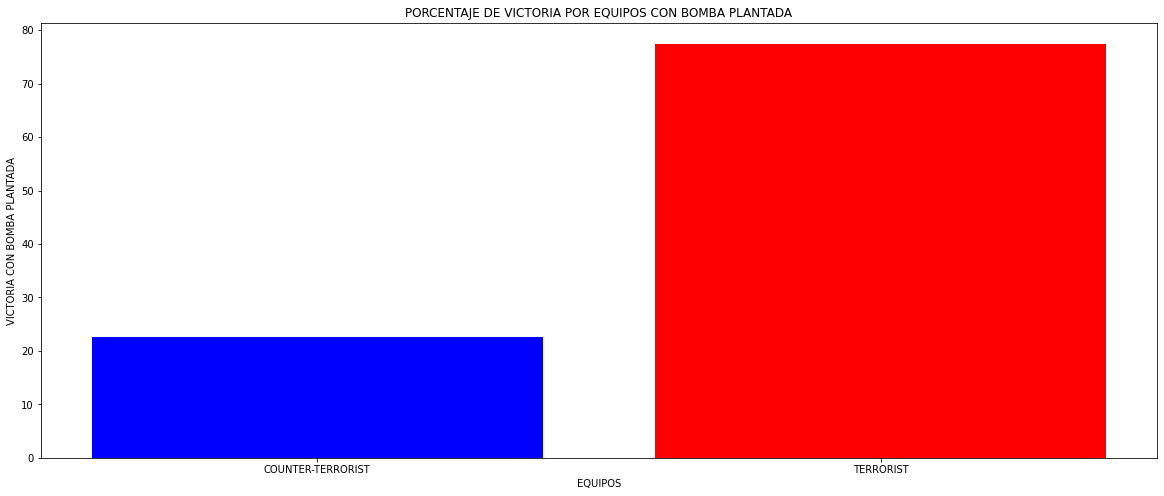

In [30]:
bomba = plt.figure(figsize=(20,8)); bomba_axes = plt.axes()

bomba_axes = plt.bar(x = victorias_bomba_plantada.index , height=victorias_bomba_plantada['PORCENTAJE DE VICTORIA %'], color = ['b','r'])

plt.xlabel('EQUIPOS')
plt.ylabel('VICTORIA CON BOMBA PLANTADA')
plt.title('PORCENTAJE DE VICTORIA POR EQUIPOS CON BOMBA PLANTADA')

plt.show()

Podemos ver una muy gran probabilidad de victoria del equipo `Terrorist` cuando logra plantar la bomba

# ¿Con qué frecuencia gana el equipo con más dinero?


#### RATIO VICTORIAS CON ECONOMIA CT MAYOR A ECONOMIA TT

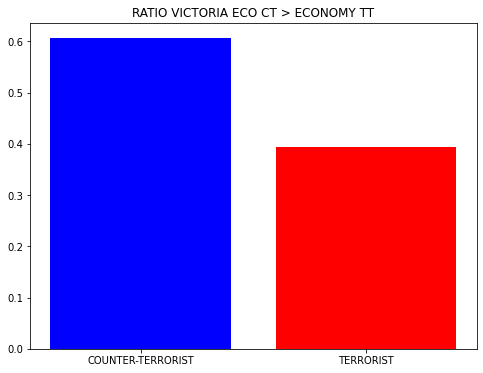

In [31]:
ratio_win_economy_ct=df[df.ct_money > df.t_money]['round_winner'].value_counts(normalize=True).to_frame()
plt.figure(figsize=(8,6))
plt.title('RATIO VICTORIA ECO CT > ECONOMY TT')
plt.bar(data =ratio_win_economy_ct, x= ['COUNTER-TERRORIST','TERRORIST'], height='round_winner', color=['blue','red'])
plt.show()

#### RATIO VICTORIAS ECONOMIA TT MAYOR A ECONOMIA CT

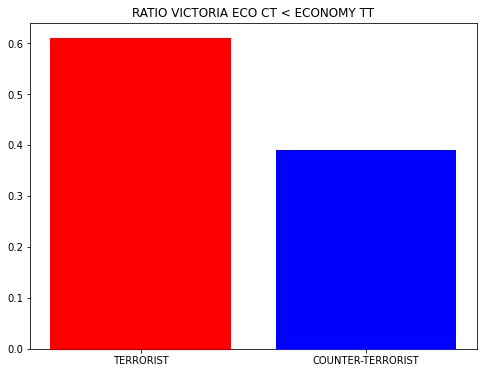

In [32]:
ratio_win_economy_tt = df[df.t_money > df.ct_money]['round_winner'].value_counts(normalize=True).to_frame()

plt.figure(figsize=(8,6))
plt.title('RATIO VICTORIA ECO CT < ECONOMY TT')

plt.bar(data =ratio_win_economy_tt, x= ['TERRORIST','COUNTER-TERRORIST'], height='round_winner', color=['red','blue'])
plt.show()

## CONCLUSION:

##### **El equipo con mejor economia en la ronda, gana en un 60% de los casos**

# ¿Son algunas armas más favorables que otras para la victoria del equipo?

In [161]:
df_weapons = df.copy().iloc[:,16:]
df_weapons.drop(df_weapons.columns[[68,69,69,70,71,72,73,74,75,76,77,78,79]], axis=1, inplace = True)

In [162]:
df_weapons = np.transpose(df_weapons.groupby('round_winner').sum()).reset_index()

df_weapons.columns = ['weapon','popularidad_win_counter-terrorist','popularidad_win_terrorist']

df_weapons['popularidad_total'] = (df_weapons['popularidad_win_counter-terrorist'] + df_weapons['popularidad_win_terrorist'])

df_weapons.head()

,weapon,popularidad_win_counter-terrorist,popularidad_win_terrorist,popularidad_total
0,ct_weapon_ak47,22304.0,11029.0,33333.0
1,t_weapon_ak47,58111.0,93381.0,151492.0
2,ct_weapon_aug,10278.0,6103.0,16381.0
3,t_weapon_aug,271.0,648.0,919.0
4,ct_weapon_awp,42310.0,27468.0,69778.0


vamos a dropear las usp y las glocks, dado que son las armas con las que se comienza en la ronda, por lo que siempre seran las que haya mayor cantidad, tambien dropearemos las armas que tengan 0 compras

In [163]:
index_weapons_0=df_weapons[df_weapons['popularidad_total']==0].index
index_weapons_glock_usp=df_weapons[np.logical_or((df_weapons.weapon=='t_weapon_glock'),(df_weapons.weapon=='ct_weapon_usps'))].index


In [164]:
df_weapons.drop(index_weapons_0, inplace = True)
df_weapons.drop(index_weapons_glock_usp, inplace = True)

#### VAMOS A TOMAR LAS 5 ARMAS QUE MAS SE UTILIZARON, PARA OBSERVAR SI HAY ALGUNAS MAS FAVORABLES QUE OTRAS PARA OBTENER LA VICTORIA.

#### LADO TT

In [167]:
df_weapons_sorted_ct_tt=df_weapons.sort_values('popularidad_total', ascending = False)
df_weapons_sorted_ct_tt[:5]


,weapon,popularidad_win_counter-terrorist,popularidad_win_terrorist,popularidad_total
1,t_weapon_ak47,58111.0,93381.0,151492.0
24,ct_weapon_m4a4,77412.0,53674.0,131086.0
49,t_weapon_sg553,37840.0,62523.0,100363.0
4,ct_weapon_awp,42310.0,27468.0,69778.0
56,ct_weapon_deagle,25423.0,28060.0,53483.0


In [151]:
# Creamos la mascara para poder dropear esas filas
df_weapons_sorted_tt_mask = df_weapons_sorted_ct_tt.weapon.apply(lambda x: re.search("ct_", x)).isnull()

df_weapons_sorted_tt_5=df_weapons_sorted_ct_tt[df_weapons_sorted_tt_mask][:5]
# Nos quedamos con las 5 armas mas populares de compra terrorista

In [152]:
df_weapons_sorted_tt_5['prob_win_tt'] = df_weapons_sorted_tt_5['popularidad_win_terrorist']/df_weapons_sorted_tt_5['popularidad_total']

df_weapons_prob_win_tt=df_weapons_sorted_tt_5.sort_values('prob_win_tt', ascending =False)
df_weapons_prob_win_tt

,weapon,popularidad_win_counter-terrorist,popularidad_win_terrorist,popularidad_total,prob_win_tt
49,t_weapon_sg553,37840.0,62523.0,100363.0,0.622969
5,t_weapon_awp,14736.0,24262.0,38998.0,0.622134
1,t_weapon_ak47,58111.0,93381.0,151492.0,0.616409
63,t_weapon_p250,15738.0,19599.0,35337.0,0.554631
57,t_weapon_deagle,24412.0,21781.0,46193.0,0.471522


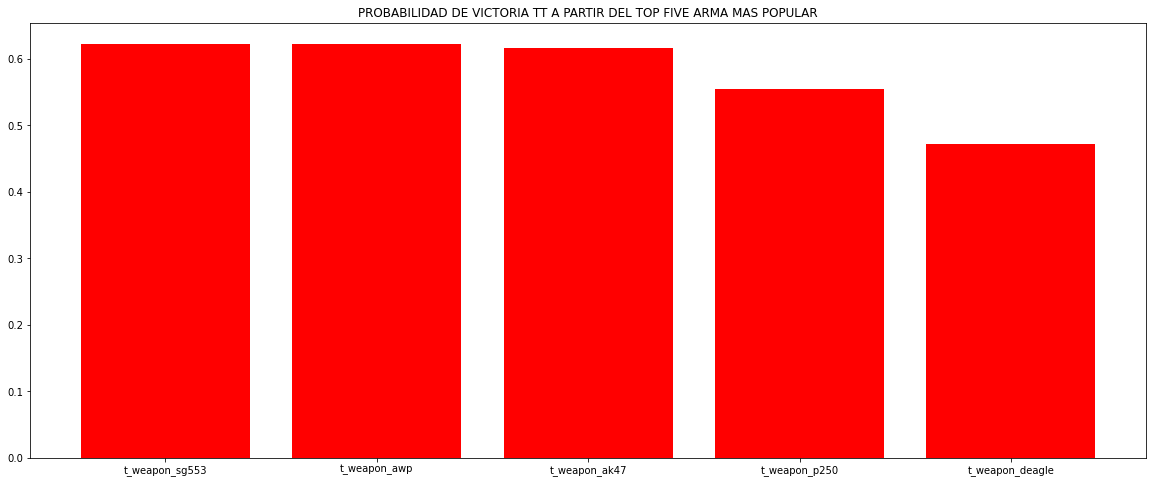

In [160]:
plt.figure(figsize=(20,8))
plt.title('PROBABILIDAD DE VICTORIA TT A PARTIR DEL TOP FIVE ARMA MAS POPULAR')

plt.bar(data = df_weapons_prob_win_tt, height = 'prob_win_tt', x = 'weapon', color = 'r')
plt.show()

#### LADO CT

In [154]:
# Creamos la mascara para poder dropear esas filas

df_weapons_sorted_ct_tt=df_weapons.sort_values('popularidad_total', ascending = False)

df_weapons_sorted_tt_mask = df_weapons_sorted_ct_tt.weapon.apply(lambda x: re.search("ct_", x)).notnull()

df_weapons_sorted_ct_5=df_weapons_sorted_ct_tt[df_weapons_sorted_tt_mask][:5]
# Nos quedamos con las 5 armas mas populares de compra counter-terrorist


In [156]:
df_weapons_sorted_ct_5=df_weapons_sorted_ct_5.sort_values('popularidad_total', ascending = False)[:5]

df_weapons_sorted_ct_5['prob_win_ct'] = \
df_weapons_sorted_ct_5['popularidad_win_counter-terrorist']/df_weapons_sorted_ct_5['popularidad_total']

df_weapons_prob_win_ct=df_weapons_sorted_ct_5.sort_values('prob_win_ct', ascending =False)
df_weapons_prob_win_ct

,weapon,popularidad_win_counter-terrorist,popularidad_win_terrorist,popularidad_total,prob_win_ct
48,ct_weapon_sg553,19772.0,9233.0,29005.0,0.681676
0,ct_weapon_ak47,22304.0,11029.0,33333.0,0.669127
4,ct_weapon_awp,42310.0,27468.0,69778.0,0.606352
24,ct_weapon_m4a4,77412.0,53674.0,131086.0,0.590544
56,ct_weapon_deagle,25423.0,28060.0,53483.0,0.475347


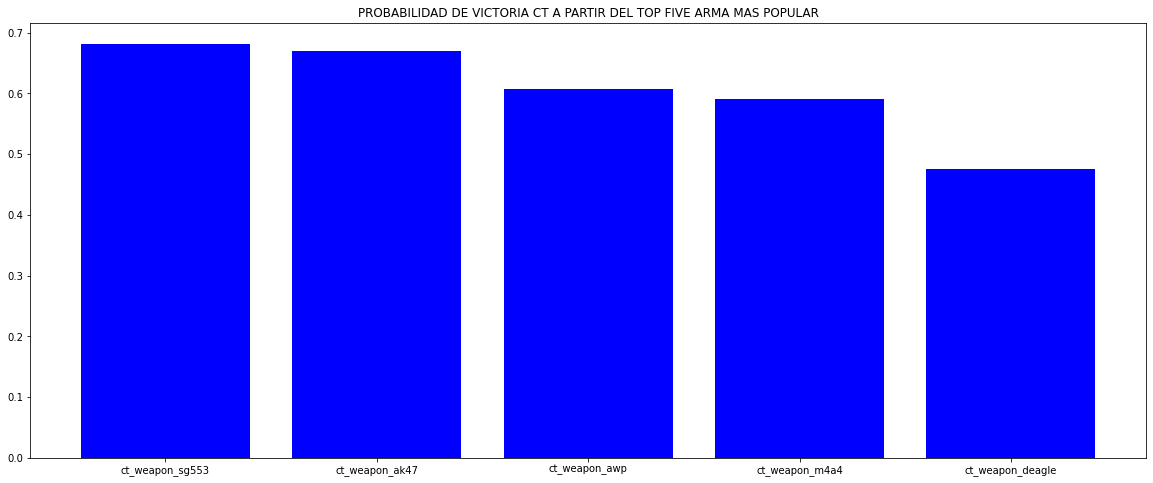

In [159]:
plt.figure(figsize=(20,8))
plt.title('PROBABILIDAD DE VICTORIA CT A PARTIR DEL TOP FIVE ARMA MAS POPULAR')

plt.bar(data = df_weapons_prob_win_ct, height = 'prob_win_ct', x = 'weapon', color = 'b')
plt.show()

## CONCLUSIONES:

**ARMAS MAS POPULARES:**

- ak47, m4a4, sg553, awp, deagle.

**ARMAS CON MAYOR PROBABILIDAD DE VICTORIA LADO ATACANTE:**
- La sg553 y la awp, 62% de prob de victoria.
- La ak47, 61.6% de prob de victoria.
- La p250, 55% de prob de victoria.

**ARMAS CON MAYOR PROBABILIDAD DE VICTORIA LADO DEFENSOR:**
- La sg553 68% de prob de victoria.
- ak47 67% de prob de victoria.
- awp 60% de prob de victoria.
- m4a4 59% de prob de victoria.


Nota: Se debe destacar que los porcentajes de victoria del lado defensor son levemente superiores a los del lado atacante, con lo que la efectividad de las armas estando apostado defendiendo, es mayor que al ingresar al site atacando.
Tambien, se debe destacar, que la ak47 que aparece entre los counter-terrorist, no puede ser comprada por ellos, por lo que previamente deben ganar una ronda para poder conseguirla, al quitarsela a un terrorist.


In [40]:
# Separamos en X e y(variable target)

X = df.drop('round_winner', axis=1)
y = df.round_winner

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=1203)

In [41]:
# Creamos los transformadores custom

class MakeDummies(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X1 = pd.get_dummies(X, columns = self.columns, drop_first = False)
        self.feature_names = X1.columns.tolist()
        return X1
    
    def get_feature_names(self):
        return self.feature_names
            
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X1 = pd.DataFrame(X[self.features])
        self.feature_names = X1.columns.tolist()
        return pd.DataFrame(X[self.features])
    
    def get_feature_names(self):
        return self.feature_names
      
    
class MakeInt(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X1 = pd.DataFrame(X[self.columns].astype(int))
        self.feature_names = X1.columns.tolist()
        return pd.DataFrame(X[self.columns].astype(int))
    
    def get_feature_names(self):
        return self.feature_names
    
    
    

#### DUMMIES PIPELINE

In [42]:
dummies_pipe = make_pipeline(FeatureSelector(['map']),
                             MakeDummies(['map']))

# dummies_pipe.fit_transform(X).sample(3)

#### INT PIPELINE

In [43]:
int_pipeline = make_pipeline(FeatureSelector(['bomb_planted']),
                             MakeInt(['bomb_planted']))

# int_pipeline.fit_transform(X).head(3)
# int_pipeline[1].get_feature_names()

#### RESTO DE COLUMNAS

In [44]:
resto_de_columnas = (X.drop(['bomb_planted','map'], axis=1)).columns

resto_de_columnas_pipeline = make_pipeline(FeatureSelector(resto_de_columnas)) 

# resto_de_columnas_pipeline.fit_transform(X).head(3)

#### UNION

Juntamos los features ya preparados, junto con el resto de las columnas, para continuar trabajando

In [47]:
union = make_union(dummies_pipe, 
                   int_pipeline,
                   resto_de_columnas_pipeline)

# Aplico la union de transformaciones a X_train
union.fit_transform(X_train)

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 4., 0., 0.]])

In [48]:
# Obtengo los nombres de todas mis features explicativas, para luego poder utilizarlas

columnas = []
for i in range (len(union.transformer_list)):
    list = union.transformer_list[i][-1][-1].get_feature_names()
    for element in list:
        columnas.append(element)

# print(columnas[:10])    

## INSTANCIAMOS UN CLASIFICADOR BASELINE

In [49]:
dc = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

accuracy_score(y_test, dc.predict(X_test))

0.5100779804388051

### **>>> Nuestro dataset dio un baseline del 51%**

## CREAMOS UN MODELO DE REGRESSION LOGISTICA

In [50]:
steps_modelo_lr = [('feature_eng', union),
                   ('estandarizacion', StandardScaler()),
                   ('estimator', LogisticRegression(C=1.0))]

In [51]:
pipe_modelo_lr = Pipeline(steps_modelo_lr)

In [52]:
# Ahora vamos a utilizar GridSearch para tunear nuestro modelo

param_grid_lr = [{'estandarizacion':[StandardScaler(), MinMaxScaler()],
                  'estimator__C': [0.0001, 0.001, 0.01]
                 }]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1203)

gs_lr = GridSearchCV(pipe_modelo_lr, param_grid_lr, n_jobs=-1, cv= skf, scoring='f1')

In [53]:
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1203, shuffle=True),
             estimator=Pipeline(steps=[('feature_eng',
                                        FeatureUnion(transformer_list=[('pipeline-1',
                                                                        Pipeline(steps=[('featureselector',
                                                                                         FeatureSelector(features=['map'])),
                                                                                        ('makedummies',
                                                                                         MakeDummies(columns=['map']))])),
                                                                       ('pipeline-2',
                                                                        Pipeline(steps=[('featureselector',
                                                                                         FeatureSelector(featur...
       't_gr

In [54]:
gs_lr.best_params_

{'estandarizacion': StandardScaler(), 'estimator__C': 0.001}

In [55]:
best_lr = gs_lr.best_estimator_

In [56]:
f1_score(y_test, best_lr.predict(X_test))

0.7503841501291397

### **Nuestra regression logistica tiene un f1 score de casi el 75%**

In [57]:
lr_coef_df = np.transpose(pd.DataFrame(abs(best_lr[2].coef_), columns = columnas))

In [58]:
lr_coef_df.columns = ['coef']
lr_coef_df.sort_values(by='coef',axis=0 , ascending = False)[:4]

,coef
ct_armor,0.491916
t_armor,0.442626
t_players_alive,0.394049
t_weapon_ak47,0.364440


### *Podemos observar que la armadura es un factor de gran relevancia para la victoria*

## CREAMOS UN MODELO DE BOOSTING

In [59]:
# steps_modelo = [ ('feature_eng', union),
#                  ('estandarizacion', StandardScaler()),
#                  ('estimador', CatBoostClassifier())]

In [172]:
steps_modelo = [('feature_eng', union),
                ('estandarizacion', StandardScaler()),
                ('estimador', LGBMClassifier(importance_type='gain'))]


In [173]:
pipe_modelo = Pipeline(steps_modelo)

In [255]:
pipe_modelo.fit(X_train, y_train)

Pipeline(steps=[('feature_eng',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featureselector',
                                                                  FeatureSelector(features=['map'])),
                                                                 ('makedummies',
                                                                  MakeDummies(columns=['map']))])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('featureselector',
                                                                  FeatureSelector(features=['bomb_planted'])),
                                                                 ('makeint',
                                                                  MakeInt(columns=['bomb_planted']))])),
                                                ('pipeline-3',...
       't_grenade_flashbang', 

In [256]:
# Accuracy del modelo, sin usar gridsearch

display('Accuracy del modelo sin GridSearch', accuracy_score(y_test, pipe_modelo.predict(X_test)),
        'f1_score del modelo sin GridSearchcv', f1_score(y_test, pipe_modelo.predict(X_test)))

'Accuracy del modelo sin GridSearch'

0.7795400475812847

'f1_score del modelo sin GridSearchcv'

0.7752021563342316

In [257]:
# Ahora vamos a utilizar GridSearch para tunear nuestro modelo

param_grid = [{'estandarizacion':[StandardScaler(), MinMaxScaler()],
               'estimador__learning_rate':[0.2], #[np.linspace(0.01,0.3,5)]
               'estimador__n_estimators':[4000] #[np.linspace(3000,4000,2)]
               }]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1203)

gs_lgbm = GridSearchCV(pipe_modelo, param_grid, n_jobs=-1, cv= skf, scoring='f1')

In [258]:
gs_lgbm.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1203, shuffle=True),
             estimator=Pipeline(steps=[('feature_eng',
                                        FeatureUnion(transformer_list=[('pipeline-1',
                                                                        Pipeline(steps=[('featureselector',
                                                                                         FeatureSelector(features=['map'])),
                                                                                        ('makedummies',
                                                                                         MakeDummies(columns=['map']))])),
                                                                       ('pipeline-2',
                                                                        Pipeline(steps=[('featureselector',
                                                                                         FeatureSelector(featur...
       't_gr

In [259]:
gs_lgbm.best_params_

{'estandarizacion': StandardScaler(),
 'estimador__learning_rate': 0.2,
 'estimador__n_estimators': 4000}

In [260]:
best_model = gs_lgbm.best_estimator_

In [261]:

f1_score(y_test, best_model.predict(X_test))

0.9094275875511664

### METRICAS

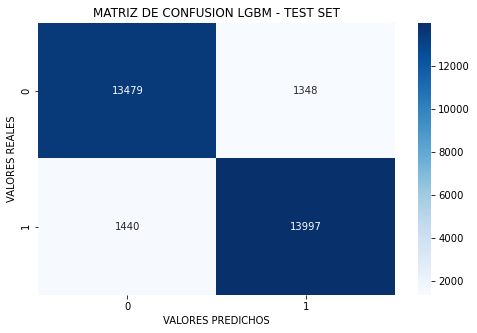

In [262]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test,best_model.predict(X_test)), annot=True, fmt='4d',cmap='Blues')
plt.xlabel('VALORES PREDICHOS')
plt.ylabel('VALORES REALES')
plt.title('MATRIZ DE CONFUSION LGBM - TEST SET')
plt.show()


In [182]:
print(classification_report(y_test,best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     14827
           1       0.91      0.91      0.91     15437

    accuracy                           0.91     30264
   macro avg       0.91      0.91      0.91     30264
weighted avg       0.91      0.91      0.91     30264



In [183]:

roc_auc_score(y_test,best_model.predict(X_test))

0.9079012021260567

**Podemos observar que nuestro modelo esta performando bastante bien**

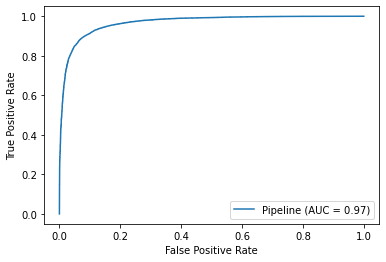

In [184]:
# curva roc
plot_roc_curve(best_model, X_test, y_test)

plt.show()

## FEATURE IMPORTANCES

In [185]:
feature_names = columnas
feature_importances = best_model[2].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importances': feature_importances})

importance_sorted =importance.sort_values('feature_importances', ascending = False).head(5)

importance_sorted

,feature_names,feature_importances
14,ct_armor,61339.384552
15,t_armor,44924.850405
16,ct_money,24356.325366
17,t_money,23557.429453
9,time_left,15533.558278


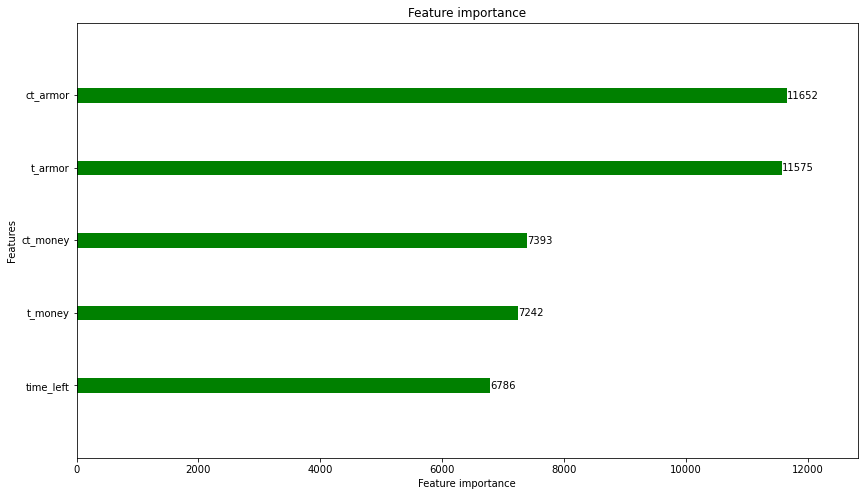

In [219]:
features_name_toplot=importance_sorted.sort_values('feature_importances', ascending = True)
ax = plot_importance(best_model[2], figsize = (14,8), max_num_features=5, color = 'g')
ax.set_yticklabels(features_name_toplot.feature_names)
plt.grid()
plt.show()

## CONCLUSIONES :

Observamos que la variable que mas influye en la victoria del equipo es la `armadura o chaleco kevlar`. 

El siguiente atributo que cobra importancia es el `dinero`.

En tercer lugar se encuentra el tiempo que le queda a la ronda.

**Ésto nos indica que la mejor estrategia es:**
- Siempre priorizar la compra del chaleco.

- Mantener una economia sana, y a la vez atacar la economia del equipo rival, en rondas "economicas", por ejemplo, o en situaciones de 1 vs 4, donde la derrota de la ronda es bastante probable, se puede mejorar las chances de victoria en rondas siguientes, atacando la economia rival.
- Ejecutar la estrategia de manera rapida, cuidando el tiempo de la ronda.


## FEATURE IMPORTANCES - PERMUTATION IMPORTANCE

Debido a el metodo que aplica esta tecnica, es necesario realizar el droppeo de features que tengan alta colinealidad con otras.

Como mencionamos antes, para realizar este estudio, vamos a eliminar t_armor, dada la alta correlacion que presenta con t_helmet, y por conocimiento de dominio, sabemos que no se puede tener helmet, sin armor.

In [79]:
df_combinacion = pd.DataFrame(data=union.fit_transform(df.drop('round_winner', axis=1)), columns=columnas)

In [80]:
X_sin_armor=df_combinacion.drop('t_armor', axis=1)

X_train_sin_armor, X_test_sin_armor, y_train_sin_armor, y_test_sin_armor=\
train_test_split(X_sin_armor, df.round_winner, stratify=df.round_winner, random_state = 1203)

In [82]:
perm_imp = permutation_importance(best_model[1:].fit(X_train_sin_armor, y_train_sin_armor), 
                                  X_test_sin_armor.sample(frac=.5, random_state=1203), 
                                  y_test_sin_armor.sample(frac=.5, random_state=1203), 
                                  scoring = 'f1', n_jobs=-1, random_state=1203)

# perm_imp.importances_mean

In [83]:
perm_imp_std=perm_imp.importances_std
perm_imp_mean=perm_imp.importances_mean
features = X_test_sin_armor.columns

perm_importance_df=pd.DataFrame(data = perm_imp_mean, index = features, columns = ['Feature_Importance'])
perm_importance_df['Standard_Desv']=perm_imp_std
perm_importance_df_sorted = perm_importance_df.sort_values('Feature_Importance', ascending = False).head(5)
perm_importance_df_sorted

,Feature_Importance,Standard_Desv
ct_armor,0.059942,0.001302
ct_money,0.059522,0.001968
t_money,0.058139,0.001425
t_helmets,0.037123,0.001285
ct_health,0.035958,0.000623


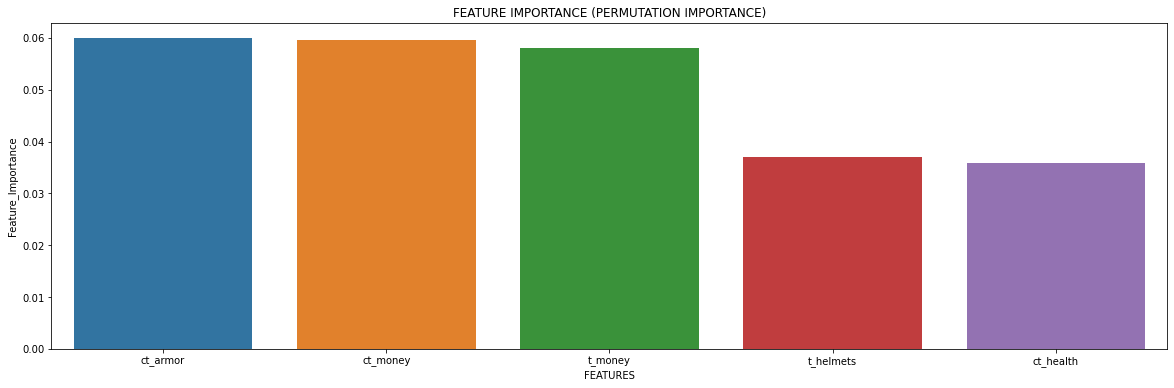

In [84]:
plt.figure(figsize=(20,6))
plt.xlabel('FEATURES')
plt.title('FEATURE IMPORTANCE (PERMUTATION IMPORTANCE)')
sns.barplot(data = perm_importance_df_sorted, x=perm_importance_df_sorted.index, y= 'Feature_Importance')
plt.show()

### CONCLUSIONES

Utilizando la tecnica de PERMUTATION IMPORTANCE, observamos que la variable explicativa que mas importancia toma para la victoria del equipo es la armadura y la economia del equipo defensor.

A continuacion le siguen la economia del equipo atacante y el uso de cascos. Probablemente esto ultimo, se deba a que el arma mas utilizada por los counter-terrorist es la m4a4, la cual mata de 1 tiro a la cabeza, si no se tiene equipado el casco.

**Esto nos deja como conclusion que:**
- Debemos tanto intentar atacar la economia del equipo rival, asi como cuidar nuestra economia, optimizando nuestras compras por ronda y resguardando las mismas.
- Debemos priorizar la compra de chaleco siempre y si estamos en el lado atacante, siempre comprar helmet.


## ESTUDIAMOS QUE FEATURES FAVORECEN LA VICTORIA DEL EQUIPO DISCRIMINANDO POR MAPA

In [85]:
df_de_dust2 =    df_combinacion.drop(['map_de_inferno','map_de_mirage','map_de_nuke'  ,'map_de_overpass', 'map_de_train' ,'map_de_vertigo','map_de_cache'],  axis=1)
df_de_mirage =   df_combinacion.drop(['map_de_inferno','map_de_dust2' ,'map_de_nuke'  ,'map_de_overpass', 'map_de_train' ,'map_de_vertigo','map_de_cache'],  axis=1)
df_de_nuke =     df_combinacion.drop(['map_de_inferno','map_de_dust2' ,'map_de_mirage','map_de_overpass', 'map_de_train' ,'map_de_vertigo','map_de_cache'],  axis=1)
df_de_inferno =  df_combinacion.drop(['map_de_mirage' ,'map_de_dust2' ,'map_de_nuke'  ,'map_de_overpass', 'map_de_train' ,'map_de_vertigo','map_de_cache'],  axis=1)
df_de_overpass = df_combinacion.drop(['map_de_inferno','map_de_dust2' ,'map_de_nuke'  ,'map_de_mirage'  , 'map_de_train' ,'map_de_vertigo','map_de_cache'],  axis=1)
df_de_vertigo =  df_combinacion.drop(['map_de_inferno','map_de_dust2' ,'map_de_nuke'  ,'map_de_overpass', 'map_de_train' ,'map_de_mirage' ,'map_de_cache'],  axis=1)
df_de_train =    df_combinacion.drop(['map_de_inferno','map_de_dust2' ,'map_de_nuke'  ,'map_de_overpass', 'map_de_mirage','map_de_vertigo','map_de_cache'],  axis=1)
df_de_cache =    df_combinacion.drop(['map_de_inferno','map_de_dust2' ,'map_de_nuke'  ,'map_de_overpass', 'map_de_train' ,'map_de_vertigo','map_de_mirage'], axis=1)


#### DE_DUST2

In [225]:
X_train_de_dust2, X_test_de_dust2, y_train_de_dust2, y_test_de_dust2 = \
train_test_split(df_de_dust2, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_dust2=best_model[1:].fit(X_train_de_dust2, y_train_de_dust2)

In [229]:
feature_names = df_de_dust2.columns
feature_importance = model_de_dust2[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(5)

importance_sorted

,feature_names,feature_importance
7,ct_armor,61494.156203
8,t_armor,45843.928381
9,ct_money,25278.908959
10,t_money,25099.686117
2,time_left,15899.148938


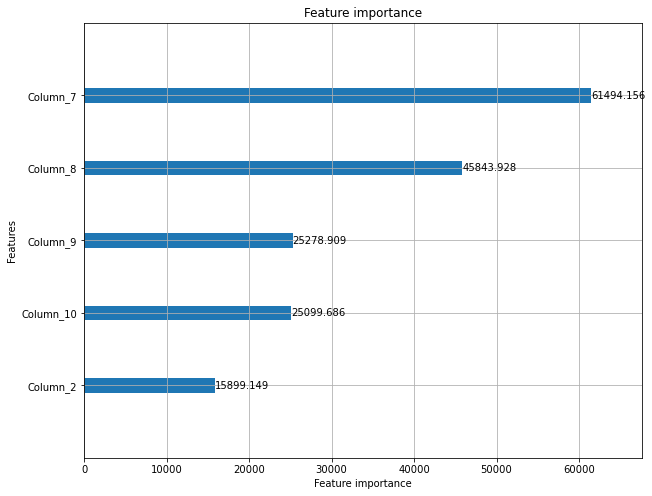

In [230]:
plot_importance(model_de_dust2[1], figsize =(10,8), max_num_features=5, importance_type='gain')
plt.show()

#### DE_MIRAGE

In [89]:
X_train_de_mirage, X_test_de_mirage, y_train_de_mirage, y_test_de_mirage = \
train_test_split(df_de_mirage, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_mirage=best_model[1:].fit(X_train_de_mirage, y_train_de_mirage)

In [239]:
feature_names = df_de_mirage.columns
feature_importance = model_de_mirage[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(5)

importance_sorted

,feature_names,feature_importance
7,ct_armor,61105.810342
8,t_armor,45840.056692
9,ct_money,25647.164830
10,t_money,25211.750838
2,time_left,16283.125018


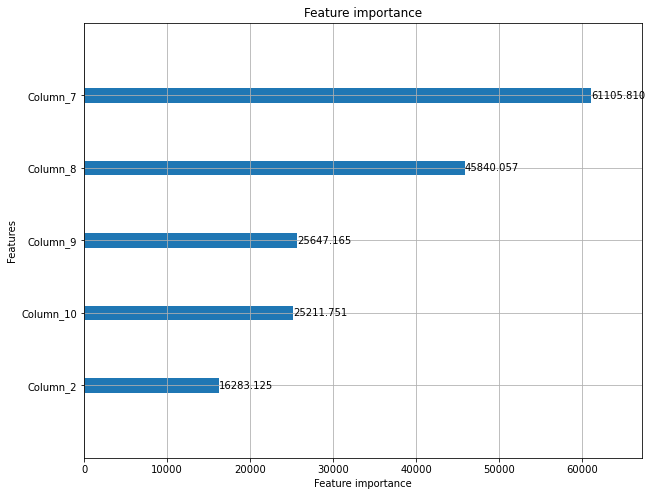

In [240]:
plot_importance(model_de_mirage[1], figsize =(10,8), max_num_features=5, importance_type='gain')
plt.show()

#### DE_NUKE

In [92]:
X_train_de_nuke, X_test_de_nuke, y_train_de_nuke, y_test_de_nuke = \
train_test_split(df_de_nuke, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_nuke=best_model[1:].fit(X_train_de_nuke, y_train_de_nuke)

In [241]:
feature_names = df_de_nuke.columns
feature_importance = model_de_nuke[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(5)

importance_sorted

,feature_names,feature_importance
7,ct_armor,61105.810342
8,t_armor,45840.056692
9,ct_money,25647.164830
10,t_money,25211.750838
2,time_left,16283.125018


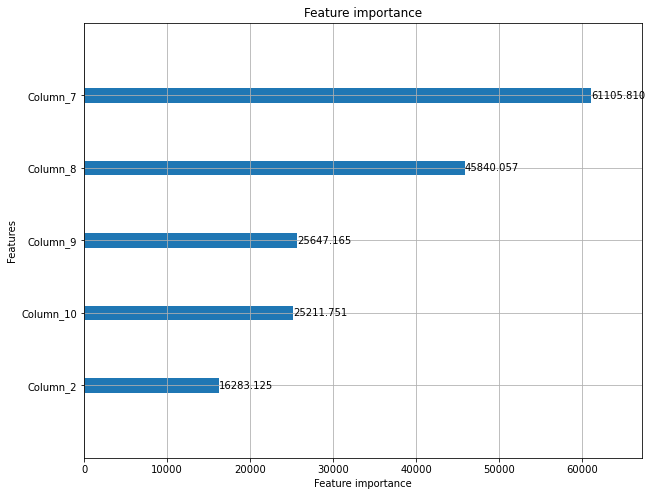

In [242]:
plot_importance(model_de_nuke[1], figsize =(10,8), max_num_features=5, importance_type='gain')
plt.show()

#### DE_INFERNO

In [95]:
X_train_de_inferno, X_test_de_inferno, y_train_de_inferno, y_test_de_inferno = \
train_test_split(df_de_inferno, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_inferno=best_model[1:].fit(X_train_de_inferno, y_train_de_inferno)

In [243]:
feature_names = df_de_inferno.columns
feature_importance = model_de_inferno[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(5)

importance_sorted

,feature_names,feature_importance
7,ct_armor,61105.810342
8,t_armor,45840.056692
9,ct_money,25647.164830
10,t_money,25211.750838
2,time_left,16283.125018


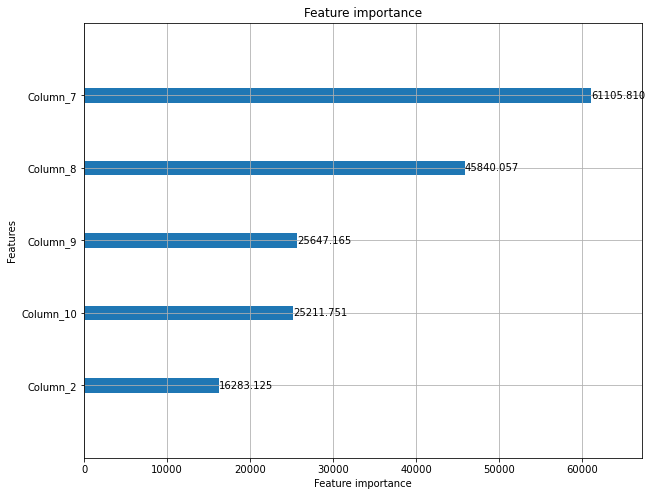

In [244]:
plot_importance(model_de_inferno[1], figsize =(10,8), max_num_features=5, importance_type='gain')
plt.show()

#### DE_OVERPASS

In [98]:
X_train_de_overpass, X_test_de_overpass, y_train_de_overpass, y_test_de_overpass = \
train_test_split(df_de_overpass, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_overpass=best_model[1:].fit(X_train_de_overpass, y_train_de_overpass)

In [245]:
feature_names = df_de_overpass.columns
feature_importance = model_de_overpass[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(5)

importance_sorted

,feature_names,feature_importance
7,ct_armor,61105.810342
8,t_armor,45840.056692
9,ct_money,25647.164830
10,t_money,25211.750838
2,time_left,16283.125018


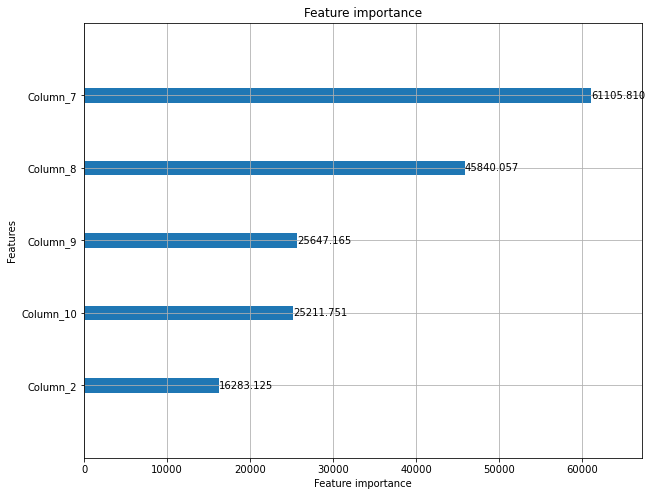

In [246]:
plot_importance(model_de_overpass[1], figsize =(10,8), max_num_features=5, importance_type='gain')
plt.show()

#### DE_VERTIGO

In [101]:
X_train_de_vertigo, X_test_de_vertigo, y_train_de_vertigo, y_test_de_vertigo = \
train_test_split(df_de_vertigo, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_vertigo=best_model[1:].fit(X_train_de_vertigo, y_train_de_vertigo)

In [247]:
feature_names = df_de_vertigo.columns
feature_importance = model_de_vertigo[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(5)

importance_sorted

,feature_names,feature_importance
7,ct_armor,61105.810342
8,t_armor,45840.056692
9,ct_money,25647.164830
10,t_money,25211.750838
2,time_left,16283.125018


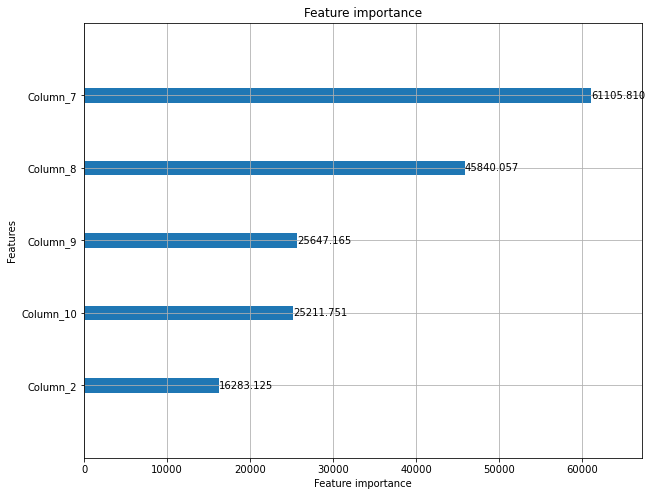

In [248]:
plot_importance(model_de_vertigo[1], figsize =(10,8), max_num_features=5, importance_type='gain')
plt.show()

#### DE_TRAIN

In [104]:
X_train_de_train, X_test_de_train, y_train_de_train, y_test_de_train = \
train_test_split(df_de_train, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_train=best_model[1:].fit(X_train_de_train, y_train_de_train)

In [249]:
feature_names = df_de_train.columns
feature_importance = model_de_train[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(5)

importance_sorted

,feature_names,feature_importance
7,ct_armor,61105.810342
8,t_armor,45840.056692
9,ct_money,25647.164830
10,t_money,25211.750838
2,time_left,16283.125018


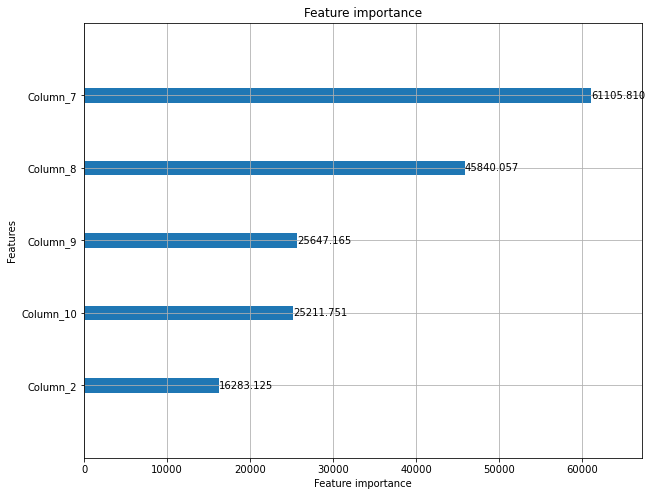

In [250]:
plot_importance(model_de_train[1], figsize =(10,8),max_num_features=5, importance_type='gain')
plt.show()

#### DE_CACHE

In [107]:
X_train_de_cache, X_test_de_cache, y_train_de_cache, y_test_de_cache = \
train_test_split(df_de_cache, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_cache=best_model[1:].fit(X_train_de_cache, y_train_de_cache)

In [251]:
feature_names = df_de_cache.columns
feature_importance = model_de_cache[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(5)

importance_sorted

,feature_names,feature_importance
7,ct_armor,61105.810342
8,t_armor,45840.056692
9,ct_money,25647.164830
10,t_money,25211.750838
2,time_left,16283.125018


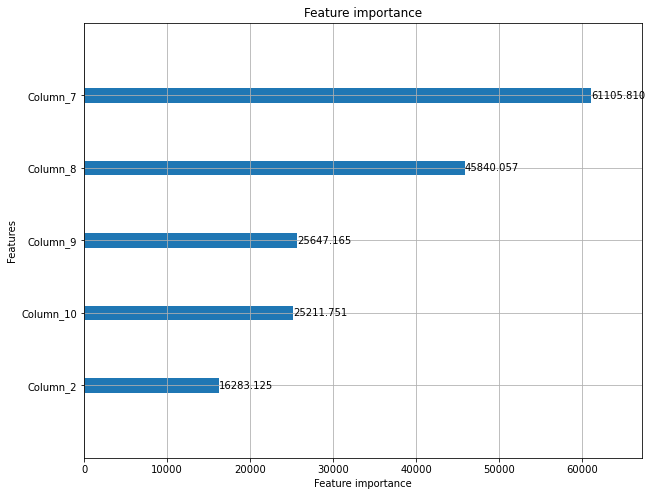

In [252]:
plot_importance(model_de_cache[1], figsize =(10,8),max_num_features=5, importance_type='gain')
plt.show()

Podemos concluir que **NO HAY** variaciones significativas en las feature importance **EN FUNCION DEL MAPA**

# DIMENSIONALITY REDUCTION

Para la reduccion de dimensionalidad utilizaremos el agoritmo BORUTA py, el cual utiliza la permutacion de features, para comparar features, contra la permutacion aleatoria de si mismas (shadow_features), y de esta manera, comprobar cuales features realmente poseen informacion util para predecir el target.

In [110]:
forest = RandomForestClassifier(
   n_jobs = -1, 
   max_depth = 5
)

###initialize Boruta

boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 100, # number of trials to perform
   random_state = 1203 
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(df_combinacion), np.array(df.round_winner))


BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=219,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F9F3294D640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F9F3294D640)

In [111]:
df_combinacion.columns[boruta.support_]

Index(['map_de_dust2', 'map_de_inferno', 'map_de_nuke', 'bomb_planted',
       'time_left', 'ct_score', 't_score', 'ct_health', 't_health', 'ct_armor',
       't_armor', 'ct_money', 't_money', 'ct_helmets', 't_helmets',
       'ct_defuse_kits', 'ct_players_alive', 't_players_alive',
       'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 'ct_weapon_awp',
       't_weapon_awp', 'ct_weapon_cz75auto', 't_weapon_cz75auto',
       'ct_weapon_famas', 't_weapon_galilar', 't_weapon_glock',
       'ct_weapon_m4a1s', 'ct_weapon_m4a4', 't_weapon_m4a4', 't_weapon_mac10',
       'ct_weapon_mp9', 'ct_weapon_sg553', 't_weapon_sg553', 'ct_weapon_ssg08',
       'ct_weapon_ump45', 't_weapon_ump45', 'ct_weapon_deagle',
       't_weapon_deagle', 'ct_weapon_fiveseven', 'ct_weapon_usps',
       't_weapon_usps', 'ct_weapon_p250', 't_weapon_p250', 'ct_weapon_p2000',
       'ct_grenade_hegrenade', 't_grenade_hegrenade', 'ct_grenade_flashbang',
       't_grenade_flashbang', 'ct_grenade_smokegrenade',
       

In [112]:
df_combinacion.columns[boruta.support_weak_]

Index(['map_de_train', 't_grenade_decoygrenade'], dtype='object')

### VAMOS A VER LAS METRICAS QUE ARROJA NUESTRO MODELO APLICANDO BORUTA

In [113]:
X_boruta=boruta.transform(np.array(df_combinacion), weak=True)

X_train_boruta, X_test_boruta, y_train_boruta, y_test_boruta = train_test_split(X_boruta, df.round_winner, stratify = df.round_winner, random_state=1203)

In [114]:
# Aplicamos nuestro grid search
# Debido a que utilizamos la data ya preprocesada, solo necesitamos los ultimos 2 steps, que son la estandarizacion y el modelo
param_grid = [{'estandarizacion':[StandardScaler(), MinMaxScaler()],
               'estimador__learning_rate':[0.3],#[0.1, 0.3, 0.5]
               'estimador__n_estimators':[4000]
               }]


gs_lgbm = GridSearchCV(pipe_modelo[1:], param_grid, n_jobs=-1, cv= skf, scoring='f1')

In [115]:
gs_lgbm.fit(X_train_boruta, y_train_boruta)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1203, shuffle=True),
             estimator=Pipeline(steps=[('estandarizacion', StandardScaler()),
                                       ('estimador',
                                        LGBMClassifier(importance_type='gain'))]),
             n_jobs=-1,
             param_grid=[{'estandarizacion': [StandardScaler(), MinMaxScaler()],
                          'estimador__learning_rate': [0.3],
                          'estimador__n_estimators': [4000]}],
             scoring='f1')

In [116]:
gs_lgbm.best_params_

{'estandarizacion': MinMaxScaler(),
 'estimador__learning_rate': 0.3,
 'estimador__n_estimators': 4000}

In [117]:
best_lgbm_boruta=gs_lgbm.best_estimator_

f1_score(y_test_boruta, best_lgbm_boruta.predict(X_test_boruta))


0.9048594181699984

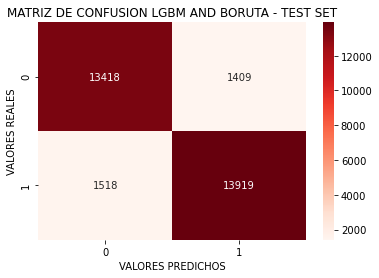

In [224]:
sns.heatmap(confusion_matrix(y_test_boruta, best_lgbm_boruta.predict(X_test_boruta)), 
            annot=True, fmt='4d',cmap='Reds')

plt.title('MATRIZ DE CONFUSION LGBM AND BORUTA - TEST SET')
plt.xlabel('VALORES PREDICHOS')
plt.ylabel('VALORES REALES')


plt.show()

In [119]:
print(classification_report(y_test_boruta, best_lgbm_boruta.predict(X_test_boruta)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     14827
           1       0.91      0.90      0.90     15437

    accuracy                           0.90     30264
   macro avg       0.90      0.90      0.90     30264
weighted avg       0.90      0.90      0.90     30264



### CONCLUSION:

**Observamos que con una reduccion de features de 96 a 34,(un poco mas de 1/3 de la cantidad original) obtenemos la misma performance, con un costo computacional menor.**

# SERIALIZACION

#### UTILIZANDO SHELVE

In [171]:
import shelve

s = shelve.open('cs_go_grupo5.db')

s['model'] = best_model

s.close()

In [ ]:
# Para el caso del modelo entrenado y que tiene la reduccion dimensional con Boruta, 
# se debe tener en cuenta que la data que se le ingrese al modelo, debe estar, preprocesada
# con el trabajo que realiza el pipeline Union

boruta_shelve = shelve.open('cs_go_grupo5_boruta.db')

boruta_shelve['model_boruta'] = best_lgbm_boruta

boruta_shelve.close()

#### UTILIZANDO PICKLE

In [ ]:
# import pickle

# with open('model_serializado.pkl', 'wb') as f:
#     pickle.dump(best_model, f)


In [ ]:
# Para el caso del modelo entrenado y que tiene la reduccion dimensional con Boruta, 
# # se debe tener en cuenta que la data que se le ingrese al modelo, debe estar, preprocesada
# # con el trabajo que realiza el pipeline Union

# with open('boruta_serializado.pkl', 'wb') as file:
#     pickle.dump(best_lgbm_boruta, file)